# Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYY MM DD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

# Part 1 ‑ Exploratory data analysis


The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
logins = pd.read_json('/Users/hayaldargin/Desktop/Springboard/Springboard_Work/Unit_26/Unit26_2_Ultimate Technologies Inc./ultimate_challenge/logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
logins.shape

(93142, 1)

In [6]:
#Aggregate these login counts based on 15 minute time intervals
logins = logins.set_index('login_time')
logins['Counter'] = 0
logins = logins.resample('15min').count()
logins = logins.reset_index()

In [7]:
logins.head()

,login_time,Counter
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


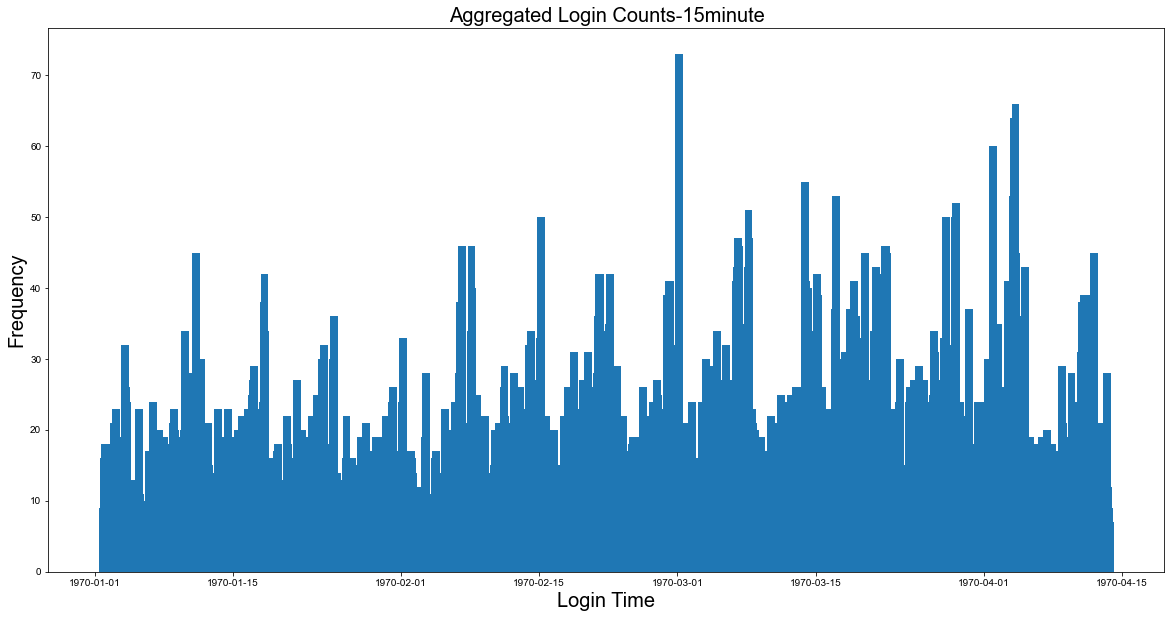

In [8]:
plt.figure(figsize=(20, 10))
plt.bar(logins.login_time, logins.Counter, data=logins)
plt.xlabel('Login Time', size = 20)
plt.ylabel('Frequency', size = 20)
plt.title('Aggregated Login Counts-15minute', size = 20)
sns.set()

Looking at daily cycles

In [9]:
logins['Day'] = logins.login_time.dt.day_name()
logins

,login_time,Counter,Day
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday
...,...,...,...
9783,1970-04-13 17:45:00,5,Monday
9784,1970-04-13 18:00:00,5,Monday
9785,1970-04-13 18:15:00,2,Monday
9786,1970-04-13 18:30:00,7,Monday


In [10]:
day_logins = logins.groupby('Day', as_index=False, sort='').sum()
day_logins.sort_values('Counter', ascending=False)

,Day,Counter
2,Saturday,19377
3,Sunday,18167
1,Friday,15208
0,Thursday,11960
6,Wednesday,10339
5,Tuesday,9268
4,Monday,8823


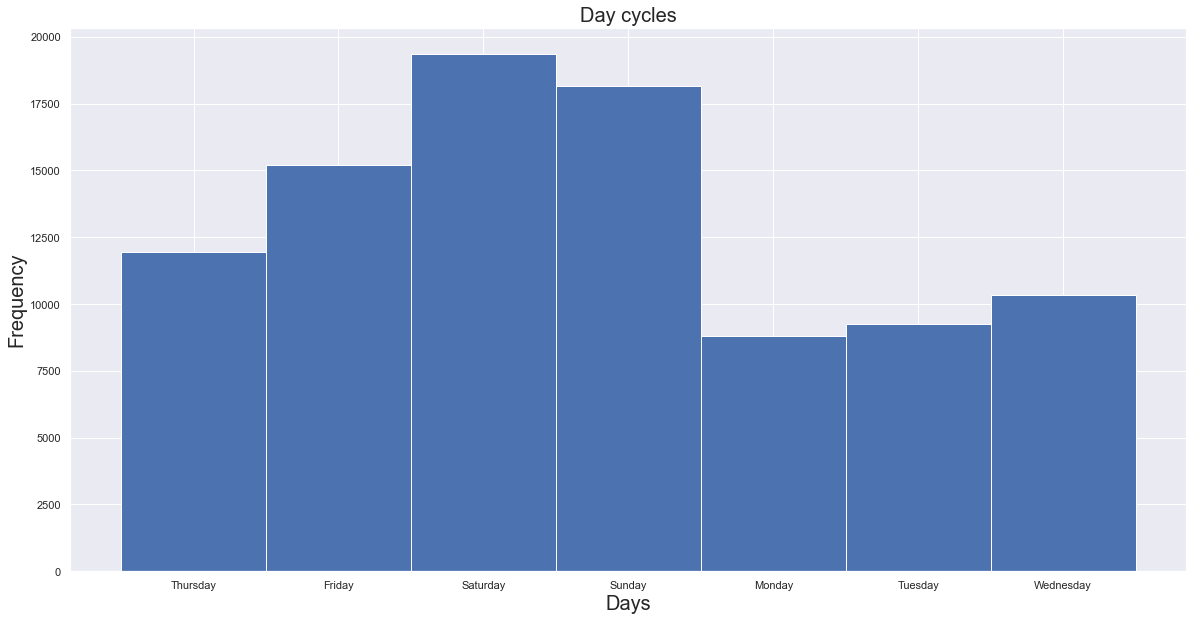

In [11]:
plt.figure(figsize=(20, 10))
plt.bar(day_logins.Day, day_logins.Counter, width=1)
plt.xlabel('Days', size = 20)
plt.ylabel('Frequency', size = 20)
plt.title('Day cycles', size = 20)
sns.set()

In [12]:
logins['Hour'] = logins.login_time.dt.hour
hour_logins = logins.groupby('Hour', as_index=False).sum()
hour_logins.sort_values('Counter', ascending=False)

,Hour,Counter
22,22,6607
1,1,6317
23,23,6058
0,0,5993
2,2,5800
11,11,5799
21,21,5623
4,4,5034
12,12,4964
3,3,4831


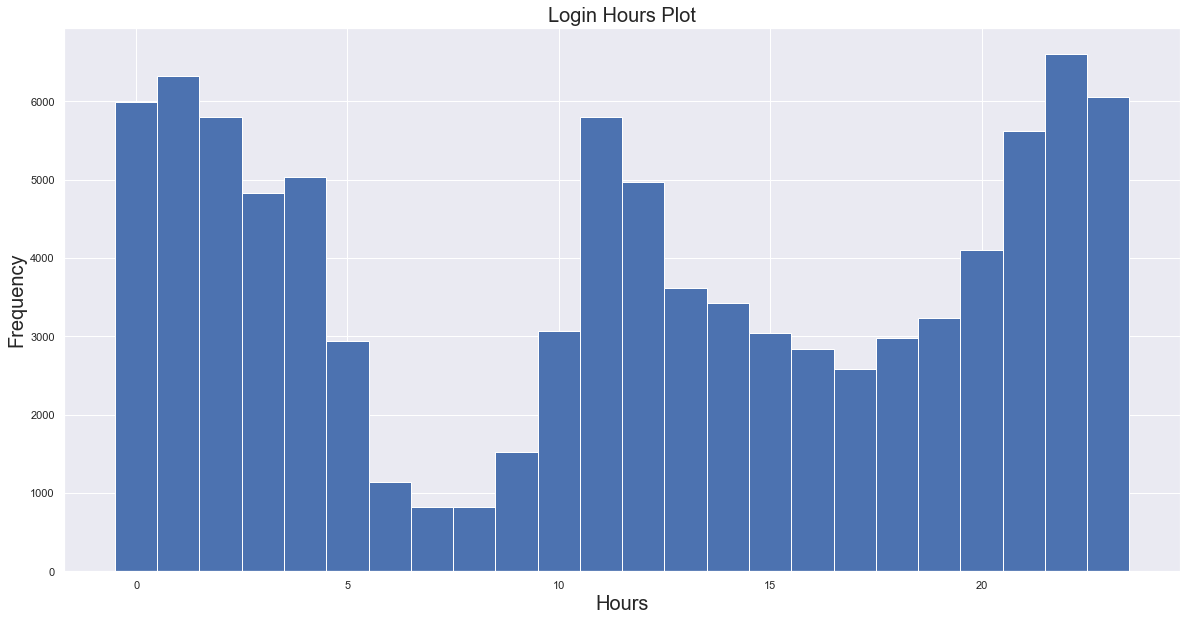

In [13]:
plt.figure(figsize=(20, 10))
plt.bar(hour_logins.Hour, hour_logins.Counter, width=1)
plt.xlabel('Hours', size = 20)
plt.ylabel('Frequency',size = 20)
plt.title('Login Hours Plot',size = 20)
sns.set()

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

###### Answer

  In this case I would choose an A/B test with random drivers reimbursed for bridge tolls, and others not. I would run the test for several weeks in order to factor out day variability and seasonality. I would also, measure bridge logins, to see if they make use of the program, and then measure user ratings, number of rides, wait times, and revenue.

# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [14]:
ultimate = pd.read_json('/Users/hayaldargin/Desktop/Springboard/Springboard_Work/Unit_26/Unit26_2_Ultimate Technologies Inc./ultimate_challenge/ultimate_data_challenge.json')
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [17]:
ultimate.shape

(50000, 12)

In [18]:
print(ultimate['avg_rating_of_driver'].min())
print(ultimate['avg_rating_of_driver'].max())
print(ultimate['avg_rating_by_driver'].min())
print(ultimate['avg_rating_by_driver'].max())

1.0
5.0
1.0
5.0


Both avg. rating columns range from 1 to 5. Let's assume a missing value means that no rating was given. In this case I will assign a '0' so I do not loose these observations.

In [19]:
ultimate['avg_rating_of_driver'] = ultimate['avg_rating_of_driver'].fillna(0)
ultimate['avg_rating_by_driver'] = ultimate['avg_rating_by_driver'].fillna(0)

The phone column contains a string for IPhone / Android. In this case let's assign most repeated ones to empty values again so as not to loose those observations.

In [20]:
ultimate['phone'] = ultimate['phone'].fillna(ultimate['phone'].mode().iloc[0])
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Next, I want to convert date.

In [21]:
# convert date columns to datetime
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [22]:
ultimate.last_trip_date.max() 

Timestamp('2014-07-01 00:00:00')

The most recent date in last_trip_date is 2014-07-01. Since the month before (June) has 30 calendar days, we can define, for our purposes, a user as active if they took a trip anywhere between June 1st and July 1st. This will be our target.

In [23]:
df = ultimate.copy()
target = (ultimate.last_trip_date < '2014-06-01').astype(int)
target.name = 'target'
target


0        0
1        1
2        1
3        0
4        1
        ..
49995    0
49996    1
49997    1
49998    1
49999    1
Name: target, Length: 50000, dtype: int64

Create dummies for phone and city.

In [24]:
city_one_hot = pd.get_dummies(df.city)

In [25]:
df.phone = pd.get_dummies(df.phone, drop_first=True)

In [26]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [27]:
days_active = pd.to_datetime(df.last_trip_date).subtract(pd.to_datetime(df.signup_date)) / np.timedelta64(1, 'D')
days_active.name = 'days_active'

In [28]:
df.ultimate_black_user = (df.ultimate_black_user).astype(int)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  uint8         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(2), ob

In [30]:
df = df.drop(columns=['city', 'signup_date', 'last_trip_date'])
df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0
1,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0
2,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0
3,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9
4,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,1,0.0,0,100.0,5.63,4.2
49996,1,0.0,1.00,1,0.0,0,0.0,0.00,4.0
49997,0,5.0,1.00,0,0.0,1,100.0,3.86,5.0
49998,2,3.0,1.00,1,0.0,0,100.0,4.58,3.5


In [39]:
dataset = pd.concat([df, city_one_hot, days_active, target], axis=1)
dataset

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,days_active,target
0,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0,0,1,0,143.0,0
1,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0,1,0,0,96.0,1
2,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0,1,0,0,1.0,1
3,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9,0,1,0,170.0,0
4,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9,0,0,1,47.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,1,0.0,0,100.0,5.63,4.2,0,1,0,131.0,0
49996,1,0.0,1.00,1,0.0,0,0.0,0.00,4.0,1,0,0,1.0,1
49997,0,5.0,1.00,0,0.0,1,100.0,3.86,5.0,0,0,1,111.0,1
49998,2,3.0,1.00,1,0.0,0,100.0,4.58,3.5,1,0,0,1.0,1


# Modeling

In [32]:
# Preprocessing
x = dataset.iloc[:,:-1].values
y = dataset.target.values

# Feature scaling
sc = StandardScaler()
x = sc.fit_transform(x)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Training model
model = LogisticRegression()
model.fit(x_train, y_train)

# Predictions
y_pred = model.predict(x_test)


In [36]:
# Evaluation
cm = confusion_matrix(y_test, y_pred)
print('Accuracy:', model.score(x_test, y_test))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Confusion Matrix:')
print(cm)


Accuracy: 0.96
AUC: 0.9585652357471419
Confusion Matrix:
[[3485  171]
 [ 229 6115]]


In [37]:
model_weights = pd.DataFrame({'features' : dataset.iloc[:,:-1].columns.tolist(), 'weights' : model.coef_.tolist()[0]})

In [38]:
model_weights.sort_values(by='weights')

,features,weights
12,days_active,-12.345470
10,King's Landing,-0.434001
5,ultimate_black_user,-0.379120
3,phone,-0.357276
0,trips_in_first_30_days,-0.250606
2,avg_surge,-0.061156
7,avg_dist,0.020882
8,avg_rating_by_driver,0.042514
4,surge_pct,0.083720
1,avg_rating_of_driver,0.087699


As we can see from the analysis, the most prominent variable in predicting user retention is the length of time that a user has had an account. This tells us that a rider who is already riding with Ultimate is likely to continue riding with Ultimate.